<a href="https://colab.research.google.com/github/rahiakela/machine-learning-research-and-practice/blob/main/hands-on-machine-learning-with-scikit-learn-keras-and-tensorflow/13-loading-and-preprocessing-data-with-tensorflow/1_tensorflow_data_api.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## The Data API

Ingesting a large dataset and preprocessing it efficiently can be tricky to implement with other **Deep Learning** libraries, but **TensorFlow** makes it easy thanks to the **Data API**: you just create a dataset object, tell it where to get the data, then transform it in any way you want, and **TensorFlow** takes care of all the implementation details, such as multithreading, queuing, batching, prefetching, and so on.

Off the shelf, the **Data API** can read from text files (such as CSV files), binary files with fixed-size records, and binary files that use **TensorFlow’s TFRecord format**, which supports records of varying sizes. TFRecord is a flexible and efficient binary format based on Protocol Buffers (an open source binary format). 

The **Data API** also has support for reading from SQL databases. Moreover, many Open Source extensions are available to read from all sorts of data sources, such as **Google’s BigQuery** service.

However, reading huge datasets efficiently is not the only difficulty: the data also needs to be preprocessed. Indeed, it is not always composed strictly of convenient numerical fields: sometimes there will be text features, categorical features, and so on.

To handle this, TensorFlow provides the **Features API**: it lets you easily convert these
features to numerical features that can be consumed by your neural network. 

For example, categorical features with a large number of categories (such as cities, or words) can be encoded using embeddings (an embedding is a trainable dense vector that represents a category).

**Data API** cover the **TFRecord format** and the **Features
API** that is related to  these projects.

* **TF Transform (tf.Transform)** makes it possible to write a single preprocessing function that can be run both in batch mode on your full training set, before training (to speed it up), and then exported to a TF Function and incorporated into your trained model, so that once it is deployed in production, it can take care of preprocessing new instances on the fly.
* **TF Datasets (TFDS)** provides a convenient function to download many common datasets of all kinds, including large ones like **ImageNet**, and it provides convenient dataset objects to manipulate them using the **Data API**.

## Setup

In [2]:
import sys
assert sys.version_info >= (3, 5)  # Python ≥3.5 is required

import sklearn 
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
assert sklearn.__version__ >= "0.20"  # Scikit-Learn ≥0.20 is required

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= '2.0'

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

if not tf.config.list_physical_devices('GPU'):
  print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")

No GPU was detected. LSTMs and CNNs can be very slow without a GPU.


## Introduction

The whole **Data API** revolves around the concept of a dataset: as you might suspect, this represents a sequence of data items. 

Usually you will use datasets that gradually read data from disk, but for simplicity let’s just create a dataset entirely in RAM:

In [3]:
X = tf.range(10)  # any data tensor
dataset = tf.data.Dataset.from_tensor_slices(X)
dataset

<TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.int32, name=None)>

You can simply iterate over a dataset’s items like this:

In [4]:
for item in dataset:
  print(item)

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32)


Equivalently

In [5]:
dataset = tf.data.Dataset.range(10)
for item in dataset:
  print(item)

tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(3, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(5, shape=(), dtype=int64)
tf.Tensor(6, shape=(), dtype=int64)
tf.Tensor(7, shape=(), dtype=int64)
tf.Tensor(8, shape=(), dtype=int64)
tf.Tensor(9, shape=(), dtype=int64)


## Chaining Transformations

Once you have a dataset, you can apply all sorts of transformations to it by calling its transformation methods. 

Each method returns a new dataset, so you can chain transformations like this.

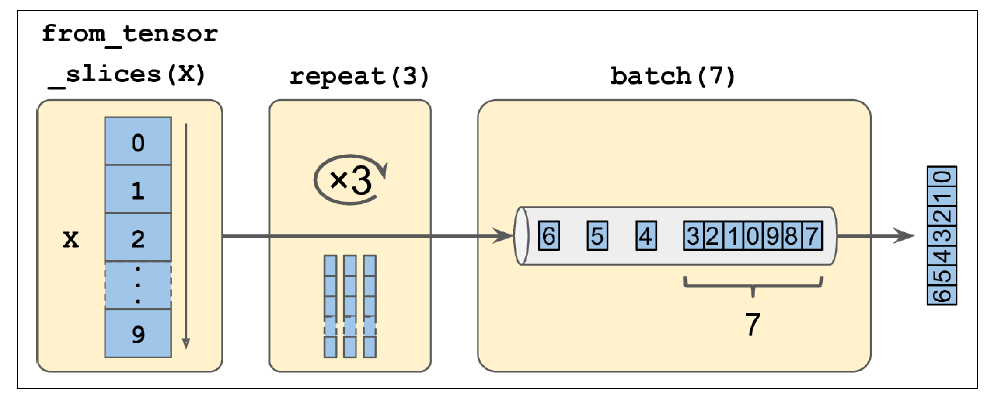

In [6]:
dataset = dataset.repeat(3).batch(7)
for item in dataset:
  print(item)

tf.Tensor([0 1 2 3 4 5 6], shape=(7,), dtype=int64)
tf.Tensor([7 8 9 0 1 2 3], shape=(7,), dtype=int64)
tf.Tensor([4 5 6 7 8 9 0], shape=(7,), dtype=int64)
tf.Tensor([1 2 3 4 5 6 7], shape=(7,), dtype=int64)
tf.Tensor([8 9], shape=(2,), dtype=int64)


Finally, we iterate over the items of this final dataset. As you can see, the batch() method had to output a final batch of size 2 instead of 7, but you can call it with `drop_remainder=True` if you want it to drop this final batch so that all batches have the exact same size.

In [7]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.repeat(5).batch(9)
for item in dataset:
  print(item)

tf.Tensor([0 1 2 3 4 5 6 7 8], shape=(9,), dtype=int64)
tf.Tensor([9 0 1 2 3 4 5 6 7], shape=(9,), dtype=int64)
tf.Tensor([8 9 0 1 2 3 4 5 6], shape=(9,), dtype=int64)
tf.Tensor([7 8 9 0 1 2 3 4 5], shape=(9,), dtype=int64)
tf.Tensor([6 7 8 9 0 1 2 3 4], shape=(9,), dtype=int64)
tf.Tensor([5 6 7 8 9], shape=(5,), dtype=int64)


In [8]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.repeat(5).batch(9, drop_remainder=True)  # discard the remainder
for item in dataset:
  print(item)

tf.Tensor([0 1 2 3 4 5 6 7 8], shape=(9,), dtype=int64)
tf.Tensor([9 0 1 2 3 4 5 6 7], shape=(9,), dtype=int64)
tf.Tensor([8 9 0 1 2 3 4 5 6], shape=(9,), dtype=int64)
tf.Tensor([7 8 9 0 1 2 3 4 5], shape=(9,), dtype=int64)
tf.Tensor([6 7 8 9 0 1 2 3 4], shape=(9,), dtype=int64)


You can also apply any transformation you want to the items by calling the `map()` method.

In [9]:
dataset = dataset.map(lambda x: x * 2)
for item in dataset:
  print(item)

tf.Tensor([ 0  2  4  6  8 10 12 14 16], shape=(9,), dtype=int64)
tf.Tensor([18  0  2  4  6  8 10 12 14], shape=(9,), dtype=int64)
tf.Tensor([16 18  0  2  4  6  8 10 12], shape=(9,), dtype=int64)
tf.Tensor([14 16 18  0  2  4  6  8 10], shape=(9,), dtype=int64)
tf.Tensor([12 14 16 18  0  2  4  6  8], shape=(9,), dtype=int64)


While the `map()` applies a transformation to each item, the `apply()` method applies a transformation to the dataset as a whole.

In [12]:
dataset1 = tf.data.Dataset.range(10)
dataset1 = dataset1.repeat(5).batch(9, drop_remainder=True)  # discard the remainder
dataset1 = dataset1.apply(tf.data.experimental.unbatch())
for item in dataset1:
  print(item)

tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(3, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(5, shape=(), dtype=int64)
tf.Tensor(6, shape=(), dtype=int64)
tf.Tensor(7, shape=(), dtype=int64)
tf.Tensor(8, shape=(), dtype=int64)
tf.Tensor(9, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(3, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(5, shape=(), dtype=int64)
tf.Tensor(6, shape=(), dtype=int64)
tf.Tensor(7, shape=(), dtype=int64)
tf.Tensor(8, shape=(), dtype=int64)
tf.Tensor(9, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(3, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(5, shape=(), dtype=int64)
tf.Tensor(6, shape=(), dtype=int64)
tf.Tensor(7, shape=(), dtype

It is also possible to simply filter the dataset using the `filter()` method:

In [13]:
dataset1 = dataset1.filter(lambda x: x < 5)
for item in dataset1:
  print(item)

tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(3, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(3, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(3, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(3, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(3, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)


You will often want to look at just a few items from a dataset. 

In [14]:
for item in dataset1.take(3):
  print(item)

tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)


In [15]:
for item in dataset1.take(5):
  print(item)

tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(3, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)


## Shuffling the Data

As you know, Gradient Descent works best when the instances in the training set are independent and identically distributed.

A simple way to ensure this
is to shuffle the instances, using the `shuffle()` method. It will create a new dataset that will start by filling up a buffer with the first items of the source dataset. 

Then, whenever it is asked for an item, it will pull one out randomly from the buffer and replace it with a fresh one from the source dataset, until it has iterated entirely through the source dataset.

At this point it continues to pull out items randomly from the buffer until it is empty. You must specify the buffer size, and it is important to
make it large enough, or else shuffling will not be very effective.

Let's create and displays a dataset containing the integers 0 to 9, repeated 3 times, shuffled using a buffer of size 5 and a random seed of 42, and batched with a batch size of 7.

In [16]:
dataset = tf.data.Dataset.range(10).repeat(3)   # 0 to 9, three times
dataset = dataset.shuffle(buffer_size=5, seed=42).batch(7)
for item in dataset:
  print(item)

tf.Tensor([0 2 3 6 7 9 4], shape=(7,), dtype=int64)
tf.Tensor([5 0 1 1 8 6 5], shape=(7,), dtype=int64)
tf.Tensor([4 8 7 1 2 3 0], shape=(7,), dtype=int64)
tf.Tensor([5 4 2 7 8 9 9], shape=(7,), dtype=int64)
tf.Tensor([3 6], shape=(2,), dtype=int64)


For a large dataset that does not fit in memory, this simple shuffling-buffer approach may not be sufficient, since the buffer will be small compared to the dataset. One solution is to shuffle the source data itself.


**Interleaving lines from multiple files**

Let’s load the California housing dataset.

In [17]:
housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)
X_mean = scaler.mean_
X_std = scaler.scale_

For a very large dataset that does not fit in memory, you will typically want to split it into many files first, then have TensorFlow read these files in parallel. 

To demonstrate this, let's start by splitting the housing dataset and save it to 20 CSV files:

In [18]:
def save_to_multiple_csv_files(data, name_prefix, header=None, n_parts=10):
  housing_dir = os.path.join("datasets", "housing")
  os.makedirs(housing_dir, exist_ok=True)
  path_format = os.path.join(housing_dir, "my_{}_{:02d}.csv")

  filepaths = []
  m = len(data)
  for file_idx, row_indices in enumerate(np.array_split(np.arange(m), n_parts)):
    part_csv = path_format.format(name_prefix, file_idx)
    filepaths.append(part_csv)
    with open(part_csv, "wt", encoding="utf-8") as f:
      if header is not None:
        f.write(header)
        f.write("\n")
      for row_idx in row_indices:
        f.write(",".join([repr(col) for col in data[row_idx]]))
        f.write("\n")
  return filepaths

In [19]:
train_data = np.c_[X_train, y_train]
valid_data = np.c_[X_valid, y_valid]
test_data = np.c_[X_test, y_test]

header_cols = housing.feature_names + ["MedianHouseValue"]
header = ",".join(header_cols)

train_filepaths = save_to_multiple_csv_files(train_data, "train", header, n_parts=20)
valid_filepaths = save_to_multiple_csv_files(valid_data, "valid", header, n_parts=10)
test_filepaths = save_to_multiple_csv_files(test_data, "test", header, n_parts=10)

Okay, now let's take a peek at the first few lines of one of these CSV files:

In [20]:
import pandas as pd

pd.read_csv(train_filepaths[0]).head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedianHouseValue
0,3.5214,15.0,3.049945,1.106548,1447.0,1.605993,37.63,-122.43,1.442
1,5.3275,5.0,6.490060,0.991054,3464.0,3.443340,33.69,-117.39,1.687
2,3.1000,29.0,7.542373,1.591525,1328.0,2.250847,38.44,-122.98,1.621
3,7.1736,12.0,6.289003,0.997442,1054.0,2.695652,33.55,-117.70,2.621
4,2.0549,13.0,5.312457,1.085092,3297.0,2.244384,33.93,-116.93,0.956


Or in text mode:

In [21]:
with open(train_filepaths[0]) as f:
  for i in range(5):
    print(f.readline(), end="")

MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedianHouseValue
3.5214,15.0,3.0499445061043287,1.106548279689234,1447.0,1.6059933407325193,37.63,-122.43,1.442
5.3275,5.0,6.490059642147117,0.9910536779324056,3464.0,3.4433399602385686,33.69,-117.39,1.687
3.1,29.0,7.5423728813559325,1.5915254237288134,1328.0,2.2508474576271187,38.44,-122.98,1.621
7.1736,12.0,6.289002557544757,0.9974424552429667,1054.0,2.6956521739130435,33.55,-117.7,2.621


In [22]:
train_filepaths

['datasets/housing/my_train_00.csv',
 'datasets/housing/my_train_01.csv',
 'datasets/housing/my_train_02.csv',
 'datasets/housing/my_train_03.csv',
 'datasets/housing/my_train_04.csv',
 'datasets/housing/my_train_05.csv',
 'datasets/housing/my_train_06.csv',
 'datasets/housing/my_train_07.csv',
 'datasets/housing/my_train_08.csv',
 'datasets/housing/my_train_09.csv',
 'datasets/housing/my_train_10.csv',
 'datasets/housing/my_train_11.csv',
 'datasets/housing/my_train_12.csv',
 'datasets/housing/my_train_13.csv',
 'datasets/housing/my_train_14.csv',
 'datasets/housing/my_train_15.csv',
 'datasets/housing/my_train_16.csv',
 'datasets/housing/my_train_17.csv',
 'datasets/housing/my_train_18.csv',
 'datasets/housing/my_train_19.csv']

**Building an Input Pipeline**

By default, the `list_files()` function returns a dataset that shuffles the file paths. 

In general this is a good thing, but you can set `shuffle=False` if you do not want that for some reason.

In [23]:
filepath_dataset = tf.data.Dataset.list_files(train_filepaths, seed=42)

In [24]:
for file_path in filepath_dataset:
  print(file_path)

tf.Tensor(b'datasets/housing/my_train_05.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_16.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_01.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_17.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_00.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_14.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_10.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_02.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_12.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_19.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_07.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_09.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_13.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_15.csv', shape=(), dtype=string)
tf.Ten

Next, you can call the `interleave()` method to read from five files at a time and
interleave their lines (skipping the first line of each file, which is the header row, using the `skip()` method):

In [25]:
n_readers = 5
dataset = filepath_dataset.interleave(lambda filepath: tf.data.TextLineDataset(filepath).skip(1), cycle_length=n_readers)

The `interleave()` method will create a dataset that will pull five file paths from the `filepath_dataset`, and for each one it will call the function you gave it to create a new dataset (in this case a TextLineDataset).

In [26]:
for line in dataset.take(5):
  print(line.numpy())

b'4.5909,16.0,5.475877192982456,1.0964912280701755,1357.0,2.9758771929824563,33.63,-117.71,2.418'
b'2.4792,24.0,3.4547038327526134,1.1341463414634145,2251.0,3.921602787456446,34.18,-118.38,2.0'
b'4.2708,45.0,5.121387283236994,0.953757225433526,492.0,2.8439306358381504,37.48,-122.19,2.67'
b'2.1856,41.0,3.7189873417721517,1.0658227848101265,803.0,2.0329113924050635,32.76,-117.12,1.205'
b'4.1812,52.0,5.701388888888889,0.9965277777777778,692.0,2.4027777777777777,33.73,-118.31,3.215'


By default, `interleave()` does not use parallelism; it just reads one line at a time from each file, sequentially. If you want it to actually read files in parallel, you can set the `num_parallel_calls` argument to the number of threads you want (note that the `map()` method also has this argument). 

